In [1]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
!pip install torchgan
!pip install tensorboardX

Uninstalling Pillow-4.1.1:
  Successfully uninstalled Pillow-4.1.1
    100% |████████████████████████████████| 2.0MB 11.9MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 133kB 4.6MB/s 


In [0]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
from torch.optim import SGD
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchgan
from torchgan.models import *
from torchgan.losses import *
from torchgan.trainer import Trainer

In [0]:
dataset = dsets.MNIST(root='./mnist', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))]), download=True)

In [0]:
dataloader = data.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=2)

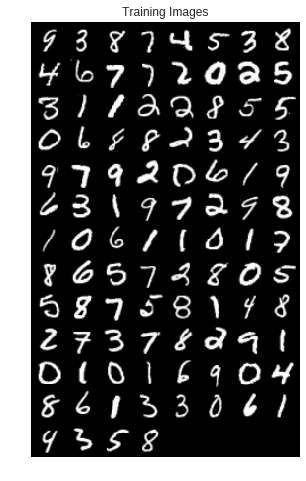

In [24]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:100], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [0]:
acgan = {
    "generator": {
        "name": ACGANGenerator,
        "args": {
            "encoding_dims": 100,
            "num_classes": 10,
            "out_channels": 1,
            "step_channels": 32,
            "out_size":32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh()
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0008,
                "betas": (0.5, 0.999)
            }
        }
    },
    "discriminator": {
        "name": ACGANDiscriminator,
        "args": {
            "in_channels": 1,
            "step_channels": 32,
            "in_size": 32,
            "num_classes": 10,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Sigmoid()
        },
        "optimizer": {
            "name": Adam,
            "args": {
                "lr": 0.0002,
                "betas": (0.5, 0.999)
            }
        }
    }
}

In [0]:
loss = [MinimaxDiscriminatorLoss(), MinimaxGeneratorLoss(), AuxiliaryClassifierGeneratorLoss(), AuxiliaryClassifierDiscriminatorLoss(),]

In [43]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.backends.cudnn.deterministic = True
    epochs = 30
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 30


In [0]:
trainer = Trainer(acgan, loss, sample_size=64, epochs=epochs, device=device)

In [45]:
trainer(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
generator Mean Gradients : 0.46766080158795253
discriminator Mean Gradients : 4.718080229126063
Mean Running Discriminator Loss : 2.141759260892868
Mean Running Generator Loss : 1.1382605614264807
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
generator Mean Gradients : 0.45397683448682014
discriminator Mean Gradients : 9.843113973455752
Mean Running Discriminator Loss : 2.1057090109586714
Mean Running Generator Loss : 1.1037878909707068
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
generator Mean Gradients : 0.4894760954303058
discriminator Mean Gradients : 13.937219270636684
Mean Running Discriminator Loss : 2.1024777549505234
Mean Running Generator Loss : 1.087454394698143
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
generat

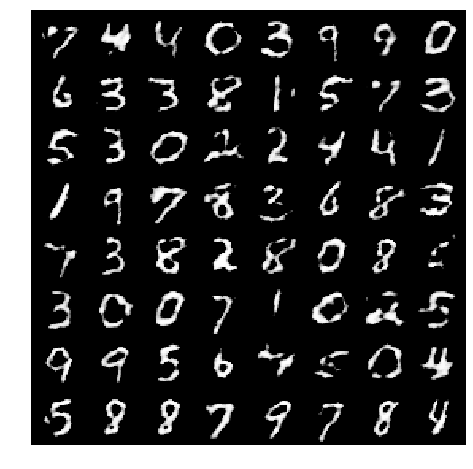

In [46]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))] for i in range(1, trainer.epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [0]:
gen = trainer.generator

In [0]:
dis = trainer.discriminator

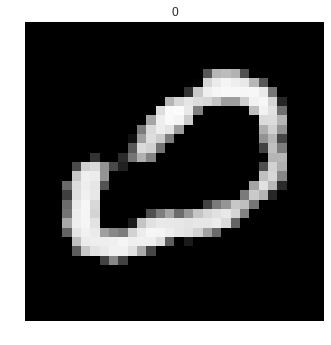

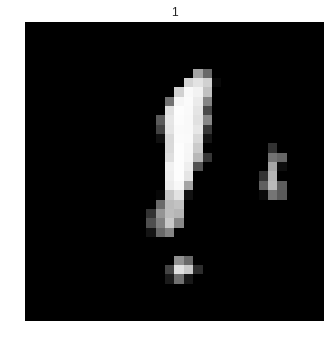

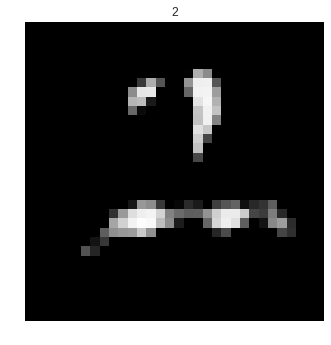

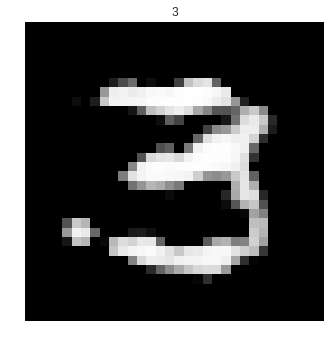

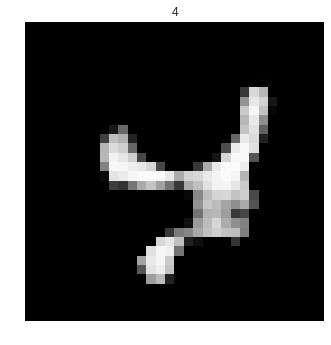

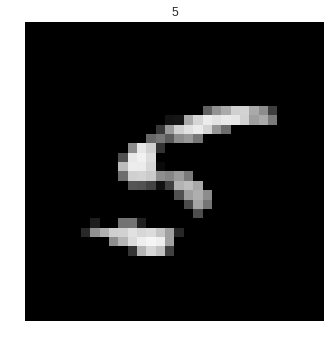

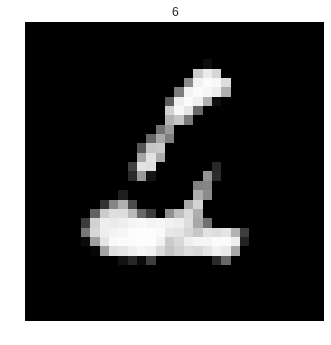

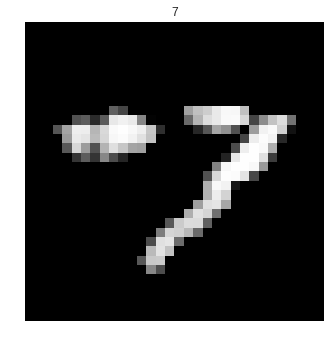

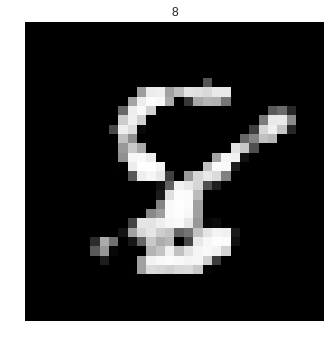

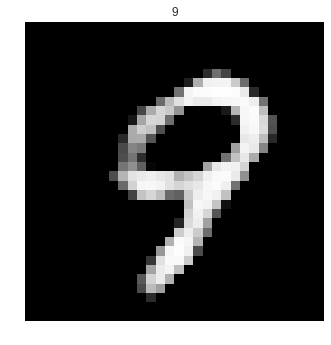

In [54]:
for i in range(10):
  x = torch.randn([1,100], device=device)
  for k in range(1000):
    xk = torch.randn([1,100], device=device)
    a = 1/dis(gen(x, torch.Tensor([i]).cuda()))
    b = 1/dis(gen(xk, torch.Tensor([i]).cuda()))
    d = (a-1)/(b-1)
    p = torch.rand([1,1], device=device)
    if (p < min(1, d)):
      x = xk
  image = gen(x, torch.Tensor([i]).cuda())
  plt.figure()
  plt.axis("off")
  plt.title(i)  
  plt.imshow(np.transpose(vutils.make_grid(image.detach()).cpu(),(1,2,0)))